In [123]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
import scipy.stats as stats

In [30]:
## Ne garder que les images non câblées

liste_non_cablees=[]
dossier="ModulePictures"

for fichier in os.listdir(dossier):
    if os.path.isfile(os.path.join(dossier, fichier)) and ("Reception" in os.path.basename(fichier)):
        liste_non_cablees.append(str(dossier + "/"+ os.path.basename(fichier)))

## Ne garder que les images câblées

liste_cablees=[]
dossier="ModulePictures"

for fichier in os.listdir(dossier):
    if os.path.isfile(os.path.join(dossier, fichier)) and ("AfterBonding" in os.path.basename(fichier)):
        liste_cablees.append(str(dossier + "/"+ os.path.basename(fichier)))


In [11]:
def mires(path, draw = True):

    #Lecture de l'image en noir et blanc
    img = cv.imread(path, cv.IMREAD_GRAYSCALE)
    assert img is not None, "file could not be read, check with os.path.exists()"

    (height,length) = img.shape

    ## TODO : changer cette extraction à la main par quelque chose d'automatisé
    sliceparams = [(100, 400, 300, 600, 1),  
                   (-400, -100, 300, 600, 1),
                   (3800, 4200, 500, 800, 2), 
                   (100, 400, -600,-300, 1), 
                   (-400, -100, -600, -300, 1), 
                   (3800, 4200, -800, -500, 2)]

    cimg = cv.cvtColor(img,cv.COLOR_GRAY2BGR)

    centers = []

    for (beg1, end1, beg2, end2, nbmires) in sliceparams :
        mask = img[beg1:end1, beg2:end2]

        #Blur pour réduire le bruit
        mask = cv.medianBlur(mask,5)
        #Fonction qui détecte les cercles.
        circles = cv.HoughCircles(mask,cv.HOUGH_GRADIENT,1,minDist = 100,
                                    param1=50,param2=20,minRadius=20 ,maxRadius=30)

        if circles is not None:
            circles = np.int16(np.around(circles))
            for i in circles[0,:nbmires]:
                
                centers.append((i[1]+beg1%height, i[0]+beg2%length)) #Attention ici j'inverse x,y afin de travailler en lignes/colonnes

                #Dessin des cercles
                if draw :
                    cv.circle(cimg,(i[0]+beg2%length,i[1]+beg1%height),i[2],(0,255,0),20)
                    cv.circle(cimg,(i[0]+beg2%length,i[1]+beg1%height),2,(0,0,255),3)

    if draw :
        plt.imshow(cimg)
        plt.show()

    assert len(centers) == 8, "Mires manquantes"

    slope = sum([(centers[i+4][0]-centers[i][0])/(centers[i+4][1]-centers[i][1]) for i in range(0,4)])/4

    return centers,slope

In [135]:
centresTest = mires(liste_non_cablees[6], False)
print(centresTest[1])

-0.0025825387365931178


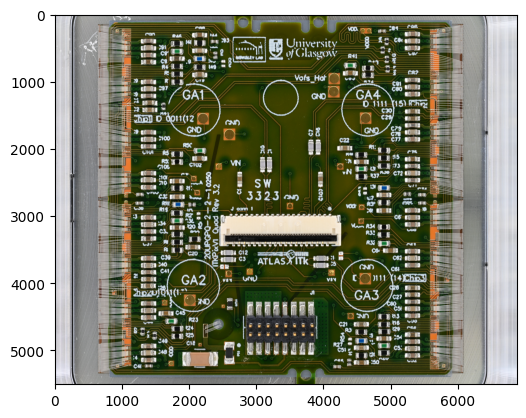

In [15]:
#un exemple
img = cv.imread(liste_cablees[0], cv.IMREAD_COLOR_RGB)
plt.imshow(img)
plt.show()

In [132]:
#Détection à la main de la frontière supérieure verte :

def slope_pcb(path) :
    img = cv.imread(path)
    def find_highest_white(col,mask):
        return min(np.where(mask[:,col] == 255))

    lower_bound = np.array([0, 40, 0])
    upper_bound = np.array([40,110,110])
    bwimg = cv.inRange(img, lower_bound, upper_bound)
    imagemask_green = cv.medianBlur(bwimg,25)

    middle = img.shape[1]//2

    cimg2 = cv.cvtColor(imagemask_green,cv.COLOR_GRAY2BGR)

    top_contour = np.zeros((1000,2),dtype=np.int32)
    bot_contour = np.zeros((1000,2),dtype=np.int32)

    for j in range(middle - 2000, middle - 1000, 2) :

        top_contour[(j - middle + 2000)//2] = [j,min(np.where(imagemask_green[:,j] == 255)[0])]
        bot_contour[(j - middle + 2000)//2] = [j,max(np.where(imagemask_green[:,j] == 255)[0])]

    for j in range(middle + 1000, middle + 2000, 2) : 

        top_contour[(j - middle)//2] = [j,min(np.where(imagemask_green[:,j] == 255)[0])]
        bot_contour[(j - middle)//2] = [j,max(np.where(imagemask_green[:,j] == 255)[0])]

    slope = 0.5*(stats.linregress(top_contour[:,0], top_contour[:,1]).slope + stats.linregress(bot_contour[:,0], bot_contour[:,1]).slope)

    return slope

In [130]:
## Trouver la colonne verte

def find_colonne(image):
    colonnes=[image[:,i,:] for i in range(image.shape[1])]
    i=0
    bool=False
    while not bool and i<len(colonnes)-1:
        col=colonnes[i]
        if (np.mean(col[:,0])+4<np.mean(col[:,1])) and (np.mean(col[:,2])+4<np.mean(col[:,1])):
            bool=True
        if not bool:
            i+=1
    return i, colonnes[i]


In [139]:
print(slope_pcb(liste_non_cablees[0]))
print(mires(liste_non_cablees[0], False)[1])


-0.0010064266437752344
-0.0012819731137874908
